# <center>Segmentation Insights: Navigating User Paths for Better Conversions</center>

<div style="text-align: center;">
    <strong>Project Proposal by Crystal Huang</strong> <br>
    Data Mining, Discovery, and Exploration <br>
    Harvard Extension School <br>
    Spring 2025
</div>

### Executive Summary

This project aims to leverage the Google Analytics 4 (GA4) e-commerce data from the [Google Merchandise Store](https://shop.googlemerchandisestore.com/) for December 2020 to address two interconnected business challenges: user segmentation and user journey analysis. By segmenting website visitors based on their browsing behavior and analyzing navigation patterns through graph-based techniques, this study seeks to provide actionable insights for targeted marketing strategies, enhanced user experiences, and improved conversion rates.

E-commerce platforms like the Google Merchandise Store face challenges in understanding how different users interact with their website and what factors contribute to conversions or drop-offs. To tackle this, this project will employ clustering algorithms to group users with similar behavioral patterns and graph-based models to analyze user journeys. Understanding common navigation paths, entry and exit points, and high-impact touchpoints will allow marketing teams to optimize engagement strategies, and streamline the conversion funnel.

By applying techniques from clustering and graph theory, this project aims to identify key customer profiles, uncover behavioral trends, and reveal insights into user pathways leading to conversions. These findings will enable businesses to refine their digital strategies, improve retention rates, and enhance overall user satisfaction.

### Data

The project will utilize the `ga4_obfuscated_sample_ecommerce` dataset available through [the BigQuery Public Datasets program](https://developers.google.com/analytics/bigquery/web-ecommerce-demo-dataset), which contains obfuscated event export data from Google Analytics 4 for the Google Merchandise Store during December 2020. The dataset includes detailed user interactions with the website, such as product views, purchases, and engagement metrics. It contains 104,315 users with 1,612,725 events.

### Data Preparation

#### Data Collection
The datasets were originally stored in BigQuery. A SQL script was executed to export the data to Google Cloud Storage, after which the data was downloaded to the local machine using `gsutil`. Following this, the data was aggregated and converted into Parquet format to facilitate further analysis.

#### Data Cleaning
The initial data cleaning process focused on removing duplicates and addressing missing values in key columns such as `user_pseudo_id`, `event_timestamp`, `event_name`, and `page_location`. The `page_title` column, which originally contained missing values, was filled using values extracted from `page_location` and cleaned for consistency; however, further mapping may be required to reduce its complexity. Columns such as `percent_scrolled` and `engagement_time_msec` were removed, as they did not provide sufficient value for analysis. Additionally, events that were automatically fired—such as `user_engagement` and `session_start` — were excluded to focus the analysis on more intentional user interactions. To ensure the dataset accurately represents genuine user behavior, users who visited the site solely for sales campaigns were also excluded to minimize potential bias. The final cleaned dataset contains 1,071,172 events across 13 columns, with 103,836 unique users and 768,210 unique sessions.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet("ga4_data/ga4_data_cleaned.parquet")
print(df.shape)
print(df.info())

(1071172, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071172 entries, 0 to 1071171
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   user_pseudo_id            1071172 non-null  object 
 1   event_bundle_sequence_id  1071172 non-null  int64  
 2   event_timestamp           1071172 non-null  object 
 3   event_name                1071172 non-null  object 
 4   device_category           1071172 non-null  object 
 5   device_mobile_brand_name  1071172 non-null  object 
 6   geo_continent             1071172 non-null  object 
 7   geo_country               1071172 non-null  object 
 8   page_location             1071172 non-null  object 
 9   page_title                1071172 non-null  object 
 10  ga_session_id             1071172 non-null  float64
 11  ga_session_number         1071172 non-null  float64
 12  event_category            1071172 non-null  object 
dtypes: float64(2)

In [3]:
print(f"Number of Unique User ID: {df.user_pseudo_id.nunique()}")
print(f"Number of Unique Sessions: {df.event_bundle_sequence_id.nunique()}")

Number of Unique User ID: 103836
Number of Unique Sessions: 768210


In [4]:
df.head()

,user_pseudo_id,event_bundle_sequence_id,event_timestamp,event_name,device_category,device_mobile_brand_name,geo_continent,geo_country,page_location,page_title,ga_session_id,ga_session_number,event_category
0,11106892.6823829951,3825301040,2020-12-01 00:23:09,page_view,mobile,Apple,Americas,United States,https://shop.googlemerchandisestore.com/signin...,The Google Merchandise Store - Log In,4.079111e+09,2.0,passive
1,26093472.8597941925,6292918624,2020-12-01 22:57:00,scroll,desktop,Google,Asia,India,https://shop.googlemerchandisestore.com/store....,Home,6.247282e+09,1.0,passive
2,74772245.0295927292,-1942011050,2020-12-01 13:28:24,scroll,desktop,Apple,Americas,United States,https://shop.googlemerchandisestore.com/basket...,Shopping Cart,4.579476e+08,1.0,passive
3,9042167.2532897443,3070506497,2020-12-01 10:57:12,view_promotion,mobile,Apple,Americas,United States,https://shop.googlemerchandisestore.com/store....,Home,2.255713e+09,1.0,engagement
4,12121539.5566979595,-802384561,2020-12-01 07:16:27,scroll,mobile,Apple,Americas,Canada,https://shop.googlemerchandisestore.com/Google...,New | Google Merchandise Store,3.791222e+09,3.0,passive


### Initial Exploratory Analysis

The initial exploratory analysis highlights key patterns in user interactions on the website. Events were categorized into three types: **passive** (e.g., `page_view`, `scroll`), **engagement** (e.g., `click`, `view_item`, `add_to_cart`), and **purchase** events (e.g., `add_payment_info`, `purchase`). To capture both the depth and breadth of user engagement, we visualized two complementary views: **total event counts** and the **number of unique users per event** (Figures 1a and 1b).

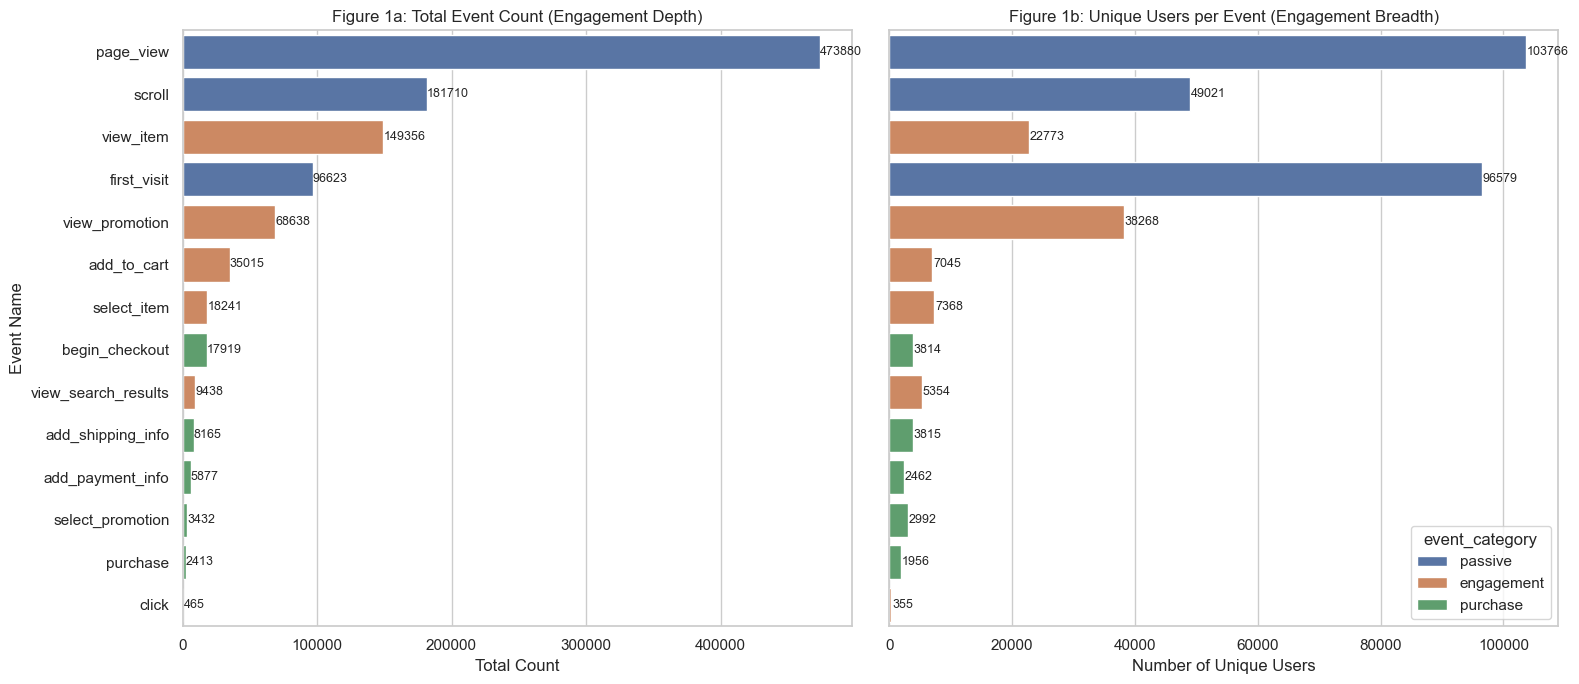

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count total event occurrences (depth)
event_counts = (
    df.groupby(['event_name', 'event_category'])
    .size()
    .reset_index(name='total_count')
)

# Count unique users per event (breadth)
user_counts = (
    df.groupby(['event_name', 'event_category'])['user_pseudo_id']
    .nunique()
    .reset_index(name='unique_users')
)

combined = pd.merge(event_counts, user_counts, on=['event_name', 'event_category'])
combined = combined.sort_values('total_count', ascending=False)

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# -------- Plot 1: Total Event Count (Depth) --------
ax1 = sns.barplot(
    data=combined,
    x='total_count',
    y='event_name',
    hue='event_category',
    dodge=False,
    ax=axes[0]
)
axes[0].set_title("Figure 1a: Total Event Count (Engagement Depth)")
axes[0].set_xlabel("Total Count")
axes[0].set_ylabel("Event Name")
ax1.legend_.remove()

# Annotate total_count
for p in ax1.patches:
    width = p.get_width()
    if width > 0:
        ax1.annotate(f'{int(width)}',
                     (p.get_x() + width + 100, p.get_y() + p.get_height() / 2),
                     ha='left', va='center', fontsize=9)

# -------- Plot 2: Unique Users per Event (Breadth) --------
ax2 = sns.barplot(
    data=combined,
    x='unique_users',
    y='event_name',
    hue='event_category',
    dodge=False,
    ax=axes[1]
)
axes[1].set_title("Figure 1b: Unique Users per Event (Engagement Breadth)")
axes[1].set_xlabel("Number of Unique Users")
axes[1].set_ylabel("")

# Annotate unique_users
for p in ax2.patches:
    width = p.get_width()
    if width > 0:
        ax2.annotate(f'{int(width)}',
                     (p.get_x() + width + 100, p.get_y() + p.get_height() / 2),
                     ha='left', va='center', fontsize=9)

# Final formatting
plt.tight_layout()
plt.show()

Figure 1a shows engagement depth, highlighting how frequently each event type was triggered. Passive events, especially `scroll` and `page_view`, dominate in volume. In contrast, Figure 1b captures engagement breadth, reflecting how many unique users performed each event. This helps reduce the influence of power users who may trigger events repeatedly. Together, the figures reveal that while passive events are both common and widespread, high-intent actions like `add_to_cart` and `purchase` are limited to a much smaller portion of users—typical of e-commerce browsing behavior.

During this analysis, the `click` event stood out as an outlier: it had significantly fewer unique users (only 355) compared to other engagement events. Upon review, this discrepancy likely stems from inconsistent tracking or limited implementation scope. To ensure consistency and avoid misinterpreting user behavior, this event will be excluded from the final analysis.

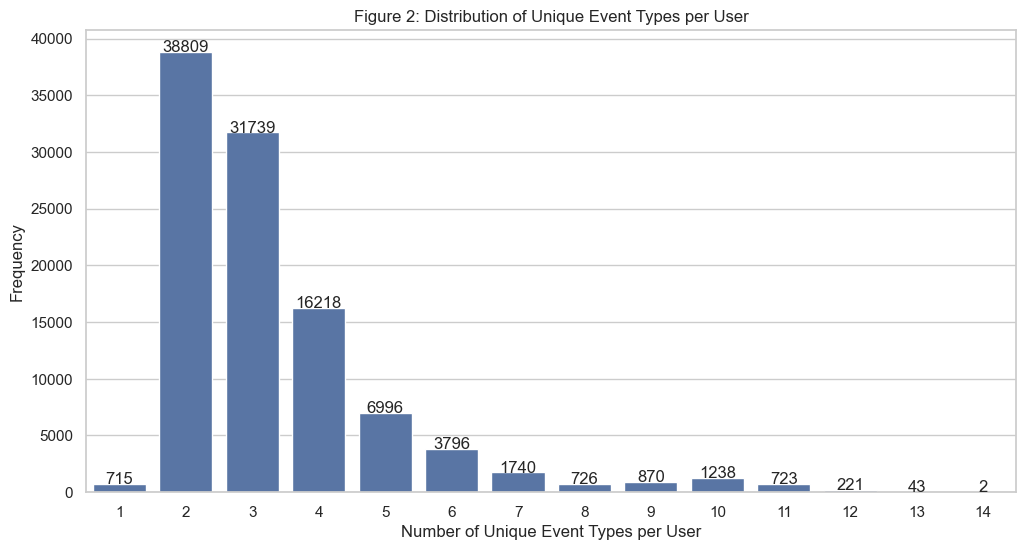

In [6]:
# Group by user and count unique events
unique_events_per_user = df.groupby("user_pseudo_id")['event_name'].nunique()

# Count occurrences of each unique event count
event_counts = unique_events_per_user.value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=event_counts.index, y=event_counts.values)

plt.xlabel('Number of Unique Event Types per User')
plt.ylabel('Frequency')
plt.title('Figure 2: Distribution of Unique Event Types per User')

# Add count labels on top of bars
for i, v in enumerate(event_counts.values):
    plt.text(i, v + 5, str(v), ha='center')

plt.show()

Examining the **Distribution of Unique Event Types per User** (Figure 2) reveals that most users engage with at least two distinct event types. This diversity in user interactions provides valuable insights for **user journey analysis**, helping to understand how users navigate through the website and what drives deeper engagement.  

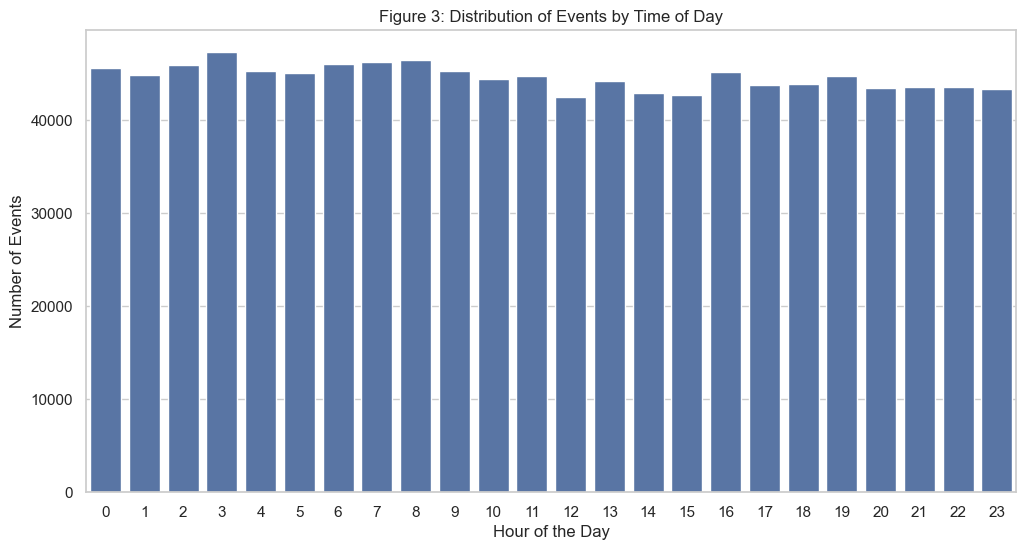

In [7]:
# Extract hour from timestamp
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
df['hour'] = df['event_timestamp'].dt.hour

# Count events per hour
hourly_event_counts = df['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_event_counts.index, y=hourly_event_counts.values)

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')
plt.title('Figure 3: Distribution of Events by Time of Day')

plt.xticks(range(0, 24))  # Ensure all hours are shown on x-axis
plt.show()

Additionally, the **Distribution of Events by Time of Day** (Figure 3) indicates that user activity remains relatively stable across different hours, suggesting a consistent flow of engagement throughout the day rather than a strong peak at specific times.

To further analyze user behavior, **session segmentation** was performed based on periods of inactivity. A session is defined as a continuous period of activity, with a new session starting after **30 minutes (1800 seconds) of inactivity**. The results indicate that the **average session duration is 169.63 seconds (2.83 minutes),** and each session consists of an average of **9 events.** Understanding session patterns helps in evaluating user engagement levels and identifying opportunities to optimize the website experience.  

Average Session Duration: 169.63 seconds (2.83 minutes)
Average Number of Events per Session: 8.70


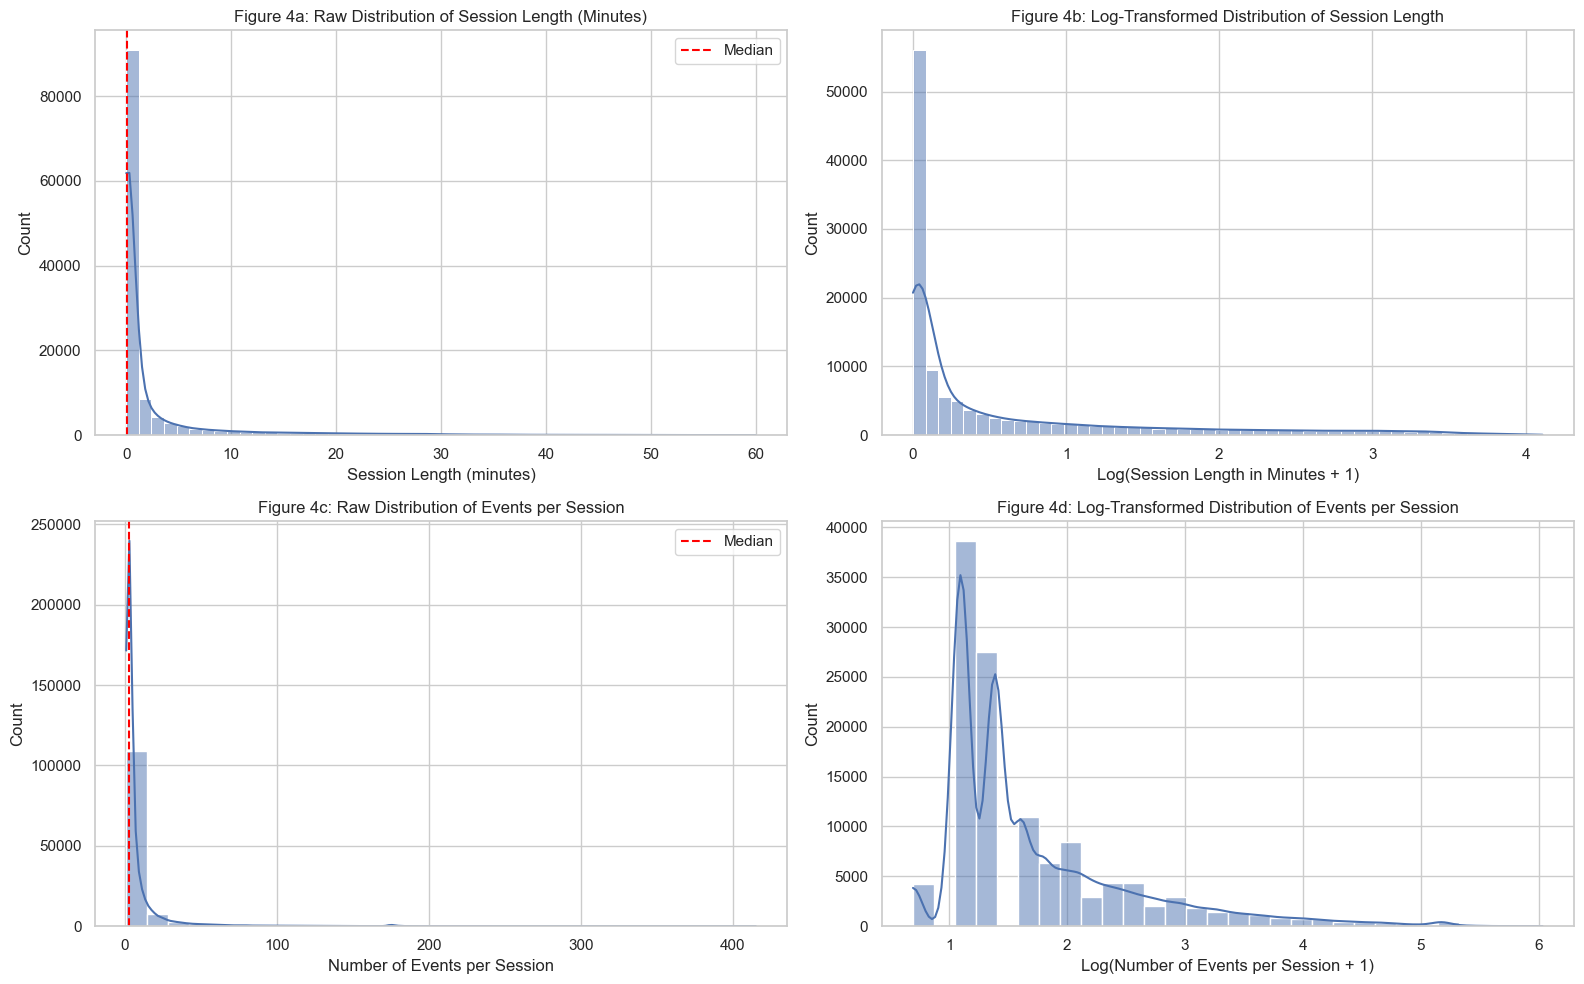

In [8]:
df = df.sort_values(by=['user_pseudo_id', 'event_timestamp'])
# identify session breaks
df['prev_event_time'] = df.groupby('user_pseudo_id')['event_timestamp'].shift()
df['time_diff'] = (df['event_timestamp'] - df['prev_event_time']).dt.total_seconds()
df['new_session'] = df['time_diff'] > 1800
df['session_id'] = df.groupby('user_pseudo_id')['new_session'].cumsum()

# compute session duration
session_duration = df.groupby(['user_pseudo_id', 'session_id']).agg(
    session_start=('event_timestamp', 'min'),
    session_end=('event_timestamp', 'max')
)

session_duration['duration'] = (session_duration['session_end'] - session_duration['session_start']).dt.total_seconds()

avg_session_duration = session_duration['duration'].mean()
print(f"Average Session Duration: {avg_session_duration:.2f} seconds ({avg_session_duration/60:.2f} minutes)")

events_per_session = df.groupby(['user_pseudo_id', 'session_id'])['event_timestamp'].count()
avg_events_per_session = events_per_session.mean()
print(f"Average Number of Events per Session: {avg_events_per_session:.2f}")

# Combine duration and event count into one dataframe
session_stats = session_duration.copy()
session_stats['event_count'] = df.groupby(['user_pseudo_id', 'session_id'])['event_timestamp'].count().values

# Optional: Filter out very long sessions for cleaner plots
session_stats = session_stats[session_stats['duration'] < 3600]

sns.set(style="whitegrid")

# Convert session duration to minutes (if not done already)
session_stats['duration_min'] = session_stats['duration'] / 60

# Set up 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Raw Distribution: Session Length (Minutes) ---
sns.histplot(session_stats['duration_min'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Figure 4a: Raw Distribution of Session Length (Minutes)")
axes[0, 0].set_xlabel("Session Length (minutes)")
axes[0, 0].axvline(session_stats['duration_min'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].legend()

# --- Log Distribution: Session Length ---
sns.histplot(np.log1p(session_stats['duration_min']), bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Figure 4b: Log-Transformed Distribution of Session Length")
axes[0, 1].set_xlabel("Log(Session Length in Minutes + 1)")

# --- Raw Distribution: Events per Session ---
sns.histplot(session_stats['event_count'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Figure 4c: Raw Distribution of Events per Session")
axes[1, 0].set_xlabel("Number of Events per Session")
axes[1, 0].axvline(session_stats['event_count'].median(), color='red', linestyle='--', label='Median')
axes[1, 0].legend()

# --- Log Distribution: Events per Session ---
sns.histplot(np.log1p(session_stats['event_count']), bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Figure 4d: Log-Transformed Distribution of Events per Session")
axes[1, 1].set_xlabel("Log(Number of Events per Session + 1)")

# Final layout adjustment
plt.tight_layout()
plt.show()

Figure 4 presents **both raw and log-transformed distributions for session length (top) and events per session (bottom)**. The raw distributions are highly right-skewed, with most sessions being short and light in interaction. The log-transformed versions reveal finer structure in mid-range behaviors, highlighting a smaller but important group of high-engagement users.

### Further Data Preparation Steps

Following the feedback on this proposal, the next steps will include refining the project plan as necessary. Key tasks will be:

- **Feature Engineering**: Derive session-level and user-level features such as session duration, number of unique pages viewed, frequency of engagement events (e.g., `add_to_cart`), and conversion signals. These features will form the basis for clustering and behavioral segmentation.

- **Normalization and Transformation**: Standardize numerical features to ensure they are on comparable scales for clustering algorithms. Categorical variables will be encoded appropriately for downstream analysis, including association rule mining.

- **Dimensionality Reduction**: Apply techniques such as Principal Component Analysis (PCA) and t-SNE to visualize relationships between users in a lower-dimensional embedding space. These projections will aid in evaluating the separability of user groups and guiding the choice of clustering algorithms and distance metrics.

These steps will help prepare the data for effective modeling, enhance interpretability of user behavior patterns, and support the discovery of actionable insights.

### Proposed Analysis Methods
To achieve the project objectives, the following methods will be employed:

1. **User Segmentation via Clustering**: Website visitors will be segmented based on behavioral features such as session duration, page views, event diversity, and purchase activity.

    - Clustering Methods: Primary models include K-Means and DBSCAN, with Agglomerative and Spectral Clustering considered for deeper insights.

    - Distance Metrics: Multiple similarity measures (e.g., Euclidean, cosine, Jaccard) will be tested to identify the most meaningful segmentation.

    - Dimensionality Reduction: PCA and t-SNE will visualize the user feature space and help assess cluster separation.

    These methods will help uncover distinct user personas and support personalization and retention strategies.

2. **User Journey Analysis with Graph-Based Models**: User navigation will be modeled as a directed graph, where nodes are pages or events and edges represent in-session transitions.

    - PageRank will identify high-impact pages.

    - Graph Clustering (e.g., spectral clustering) will uncover common navigation paths.

    - Session Path Analysis will highlight entry/exit points and drop-offs.

    This analysis will reveal key behaviors and friction points in the user journey.

3. **Advanced Analyses (Time Permitting)**: If time and scope allow, the project will explore the following methods to augment segmentation and journey analysis:

    - Similarity Search: Compare users based on page navigation patterns, especially across behavioral groups (e.g., browsers vs. purchasers).

    - Frequent Itemset Mining: Use Apriori or FP-Growth to find common combinations of page visits and actions.
    These methods will further support personalization, retargeting, and journey optimization.

By combining clustering, graph modeling, and pattern mining, this project will provide a comprehensive view of user behavior on the Google Merchandise Store. The insights will support data-driven decisions to improve user experience, boost marketing effectiveness, and increase conversions.